# Predicting User Churn

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Data-formatting" data-toc-modified-id="Data-formatting-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data formatting</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Analysis</a></span><ul class="toc-item"><li><span><a href="#User-Churn" data-toc-modified-id="User-Churn-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>User Churn</a></span></li><li><span><a href="#Input-Features" data-toc-modified-id="Input-Features-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Input Features</a></span></li></ul></li><li><span><a href="#Prep-for-modeling" data-toc-modified-id="Prep-for-modeling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prep for modeling</a></span><ul class="toc-item"><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Feature Selection</a></span></li><li><span><a href="#Train/Test-Split" data-toc-modified-id="Train/Test-Split-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Train/Test Split</a></span></li></ul></li><li><span><a href="#Classifier" data-toc-modified-id="Classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Classifier</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
from time import time
from datetime import datetime
plt.style.use('seaborn')

## Loading Data
The "data" file contains individual login timestamps. I can use this data to find trends in usage behavior for each user over the test period.

"Target" file contains information about each unique user. This includes our outcome variable, churn, indicating whether the user continued to use the app a month after the test period ended.

In [320]:
data_filename = 'data.csv'
target_filename = 'targets.csv'
data = pd.read_csv(data_filename)
target = pd.read_csv(target_filename)
display(data.head())
print(data.shape)
display(target.head())
print(target.shape)

,app,user,platform,ts
0,Verified Ax,804f9d19-0988-4c5b-a6de-2cb39776ef60,ios,2015-06-01T00:01:05
1,"MacGuffins, LLC",c6d3181b-b257-4122-80cc-e71c07669023,android,2015-06-01T00:12:17
2,Verified Ax,bc415f94-a2b2-4935-966b-1cda0f69eb1a,android,2015-06-01T00:13:05
3,"MacGuffins, LLC",d3b12198-d1cf-4438-9fe7-19787c4cfacc,ios,2015-06-01T00:13:10
4,OnTheGo Cap'n,14873b91-a68d-4cbf-bceb-193c5180faae,android,2015-06-01T00:13:39


(71387, 4)


,app,user,platform,target
0,Verified Ax,804f9d19-0988-4c5b-a6de-2cb39776ef60,ios,1
1,"MacGuffins, LLC",c6d3181b-b257-4122-80cc-e71c07669023,android,1
2,Verified Ax,bc415f94-a2b2-4935-966b-1cda0f69eb1a,android,1
3,"MacGuffins, LLC",d3b12198-d1cf-4438-9fe7-19787c4cfacc,ios,1
4,OnTheGo Cap'n,14873b91-a68d-4cbf-bceb-193c5180faae,android,0


(7527, 4)


## Data formatting
The first formatting to do is change string dates to datetime format. Then we extract time of day and day of week information.

I set up the "target" dataframe with the user as index so I can pass feature columns from "data" to "target".

Pandas "weekday" method defines Monday as 0, and the "hour" method starts 0 at midnight.

In [321]:
data['ts'] = pd.to_datetime(data['ts'], infer_datetime_format=True)
data['hour'] = data['ts'].dt.hour
data['weekday'] = data['ts'].dt.weekday
data['weekday_name'] = data['ts'].dt.weekday_name
data_group_user = data.groupby('user', sort=False)

In [322]:
data.head(1)

,app,user,platform,ts,hour,weekday,weekday_name
0,Verified Ax,804f9d19-0988-4c5b-a6de-2cb39776ef60,ios,2015-06-01 00:01:05,0,0,Monday


In [323]:
data['weekday_name'].value_counts()

Monday       11777
Saturday     10981
Sunday       10894
Friday        9923
Tuesday       9753
Wednesday     9144
Thursday      8915
Name: weekday_name, dtype: int64

In [324]:
if target.index.name != 'user':
    target.set_index('user', inplace=True)
target.rename(columns = {'target':'user_churned'}, inplace = True)

## Feature engineering
Aggregating whatever data I can from the "data" dataframe, grouped by user. I use the total count of app opens, the first and last open times, and the most likely time of day and day of week of open, and then make some binary features of whether the user opened the app in the first week, first month, and/or the last week. These features have been iterated over after doing some of the exploratory data analysis below.
* Note: The median of an even set of numbers is the mean of the two center values; this is how I end up with 'open_day' of half-values. Those indicate that the median is directly between the two day values.

In [325]:
target['open_count'] = data_group_user['ts'].count()
target['first_open'] = data_group_user['ts'].min()
target['last_open'] = data_group_user['ts'].max()
target['open_time'] = data_group_user['hour'].median()
target['open_day'] = data_group_user['weekday'].median()
target['opened_in_first_week'] = np.where(target['first_open'] < datetime(2015, 6, 8), 1, 0)
target['opened_in_first_month'] = np.where(target['first_open'] < datetime(2015, 7, 1), 1, 0)
target['opened_in_last_week'] = np.where(target['last_open'] >= datetime(2015, 8, 25), 1, 0)

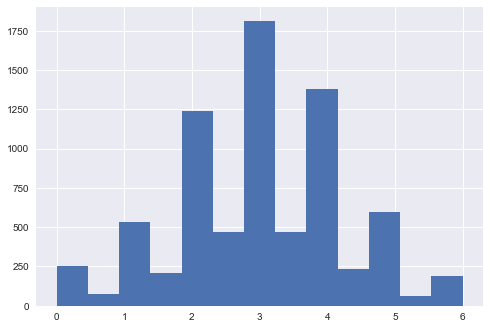

In [326]:
plt.hist(target['open_day'], bins=13)
plt.show()

In [327]:
display(target.head(1))
print(target.dtypes)

,app,platform,user_churned,open_count,first_open,last_open,open_time,open_day,opened_in_first_week,opened_in_first_month,opened_in_last_week
user,,,,,,,,,,,
804f9d19-0988-4c5b-a6de-2cb39776ef60,Verified Ax,ios,1,6,2015-06-01 00:01:05,2015-07-26 17:41:45,9.0,5.0,1,1,0


app                              object
platform                         object
user_churned                      int64
open_count                        int64
first_open               datetime64[ns]
last_open                datetime64[ns]
open_time                       float64
open_day                        float64
opened_in_first_week              int32
opened_in_first_month             int32
opened_in_last_week               int32
dtype: object


## Data Analysis

### User Churn
The first thing to check for is our classes of outcome variable.

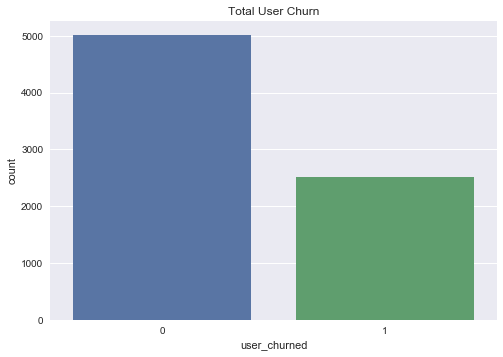

In [328]:
ax = sns.countplot(x='user_churned', data=target)
ax.set_title('Total User Churn')
plt.show()

So we have some class imbalance here; not really enough to have to correct for it. Twice as many users stayed as left.

### Input Features
The next step is to look at the ranges of our input features, separated by their correlation with the outcome classes. Here I show the distribution of the dates of first and last open, with the color indicating whether the user ended up churning or not: green designates the user as having churned, and blue as not.

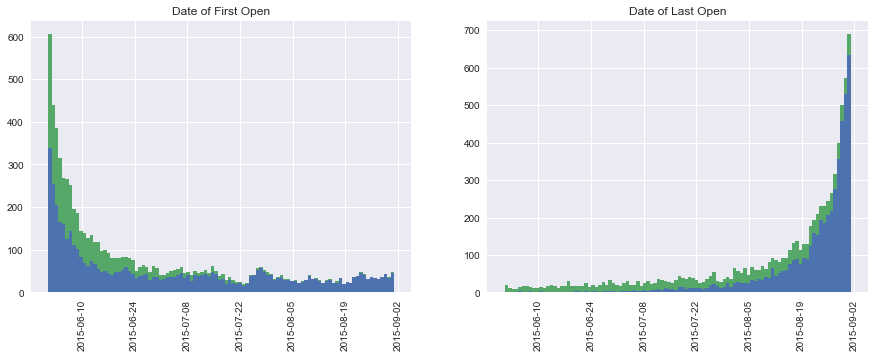

In [329]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist([target.loc[(target['user_churned'] == 0), 'first_open'].values, target.loc[(target['user_churned'] == 1), 'first_open'].values], bins=100, stacked=True)
plt.xticks(rotation=90)
plt.title('Date of First Open')
plt.subplot(122)
plt.hist([target.loc[(target['user_churned'] == 0), 'last_open'].values, target.loc[(target['user_churned'] == 1), 'last_open'].values], bins=100, stacked=True)
plt.xticks(rotation=90)
plt.title('Date of Last Open')
plt.show()

This dataset is skewed heavily toward people who started early and those who continued until near the end. Those are obviously not necessarily the same people, as is clear from the distribution of churned users in each plot.

Churned users are concentrated in the first month of the "First Open" plot, and spread evenly across the "Last Open" plot, until about a week before the end of the test period. Most people who continued to use the app into the last week then kept using the app later.

Additionally, people who last used the app during the first month were very likely to have churned already. Engineering a feature on that metric is highly likely to be predictive, but I think that will overfit our model. Since those users already churned, it is too related to our outcome variable to be explanatory.

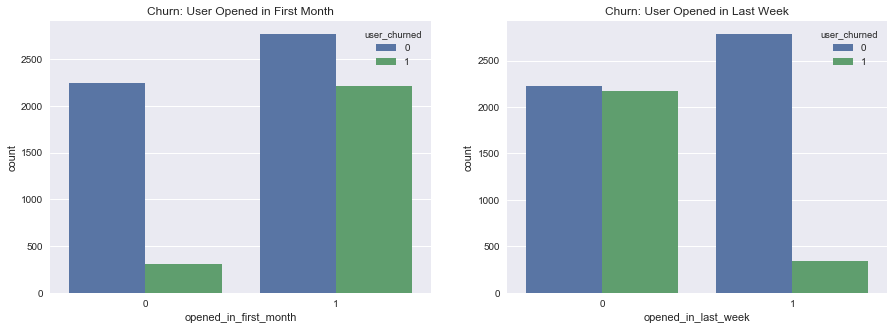

In [330]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
ax1 = sns.countplot(x='opened_in_first_month', hue='user_churned', data=target)
ax1.set_title('Churn: User Opened in First Month')
plt.subplot(122)
ax2 = sns.countplot(x='opened_in_last_week', hue='user_churned', data=target)
ax2.set_title('Churn: User Opened in Last Week')
plt.show()

This shows some stark contrast in user churn by first and last time opened. Users who first opened the app after the first month of the test period were far more likely to continue using it later. Less surprisingly, users who opened the app within the last week were also far less likely to churn later.

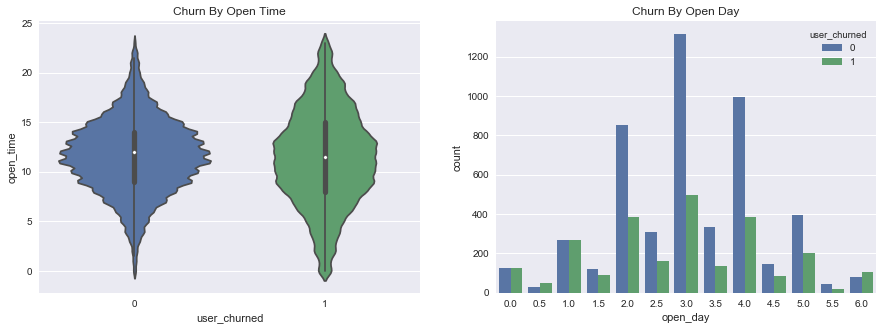

In [331]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
ax = sns.violinplot(x='user_churned', y='open_time', data=target, bw=0.1)
ax.set_title('Churn By Open Time')
plt.subplot(122)
ax = sns.countplot(x='open_day', hue='user_churned', data=target)
ax.set_title('Churn By Open Day')
plt.show()

"Open time" and "open day" have slightly different distributions based on users' churn, but the predictive power doesn't appear to be very strong.

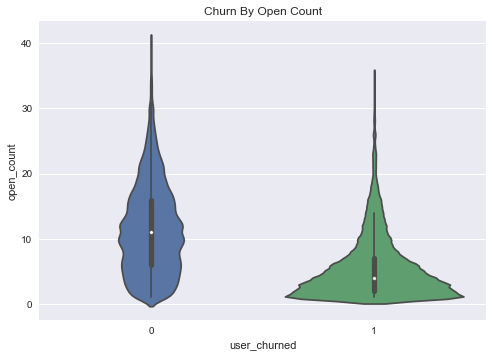

In [332]:
ax = sns.violinplot(x='user_churned', y='open_count', data=target, bw=0.1)
ax.set_title('Churn By Open Count')
plt.show()

The distributions of "open count" based on user churn are completely different, indicating that it should be highly predictive.

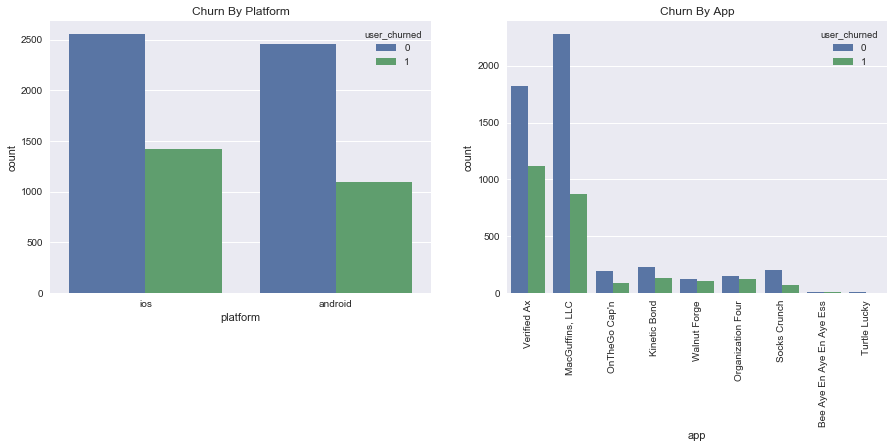

In [333]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
ax = sns.countplot(x='platform', hue='user_churned', data=target)
ax.set_title('Churn By Platform')
plt.subplot(122)
ax = sns.countplot(x='app', hue='user_churned', data=target)
ax.set_title('Churn By App')
plt.xticks(rotation=90)
plt.show()

Choice of app and platform don't appear to have much predictive power, and are much less interesting with respect to explanatory power as well, since we would ideally want to predict churn independent of platform or app.

## Prep for modeling

In [334]:
target.columns

Index(['app', 'platform', 'user_churned', 'open_count', 'first_open',
       'last_open', 'open_time', 'open_day', 'opened_in_first_week',
       'opened_in_first_month', 'opened_in_last_week'],
      dtype='object')

### Feature Selection
I first modeled using all the features, but the random forest's "feature importances" indicated that "open count", "opened in last week", and "opened in first month" were much more important than the others. The second iteration used only those three features, increasing the stability of the cross validation scores.

In [335]:
# This code slice causes the model to use all numeric features.

# x1 = pd.get_dummies(target[['app', 'platform']])
# x2 = target.drop(['user_churned', 'first_open', 'last_open', 'app', 'platform'], axis=1)
# X = pd.concat([x1, x2], axis=1)

In [336]:
# This uses only the most important three features.

X = target[['open_count', 'opened_in_last_week', 'opened_in_first_month']]
Y = target['user_churned']

### Train/Test Split
This reduces the chance of overfitting by predicting only on a set-aside random slice of the data.

In [337]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [338]:
print(X_train.shape, X_test.shape)

(6021, 3) (1506, 3)


In [339]:
print(Y_train.value_counts())
print(Y_test.value_counts())

0    4008
1    2013
Name: user_churned, dtype: int64
0    1004
1     502
Name: user_churned, dtype: int64


## Classifier

In [340]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

model_type = 'r'

if (model_type == 'r'):
    model = RandomForestClassifier(n_estimators=500, 
                                   max_depth=5, 
                                   max_features='auto', 
                                   min_samples_split=10)
if (model_type == 'l'):
    model = LogisticRegression(C=1.0, 
                               penalty='l1')
if (model_type == 'g'):
    model = GradientBoostingClassifier(n_estimators=200, 
                                       max_depth=5, 
                                       min_samples_split=10)


t0 = time()
model.fit(X_train, Y_train)
print('Model fit runtime: {:.2f} s'.format(time()-t0))

from sklearn.model_selection import cross_val_score
t0 = time()
cv = cross_val_score(model, X_train, Y_train, cv=5)
print('CV runtime: {:.2f} s'.format(time()-t0))

Model fit runtime: 1.16 s
CV runtime: 5.53 s


In [343]:
score_train = model.score(X_train, Y_train)
score_test = model.score(X_test, Y_test)

print('Training set score: {:.2%}'.format(score_train))
plusminus = u"\u00B1"
print('\nCross validation score: {:.2%} {} {:.2%}\n\n{}'.format(cv.mean(), plusminus, cv.std()*2, cv))
print('\nTest set score: {:.2%}'.format(score_test))

from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X_test)
test_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred))
test_cm.index.name = 'Actual Churn'
test_cm.columns.name = 'Predicted Churn'
display(test_cm)

FP = test_cm.loc[0, 1]
FN = test_cm.loc[1, 0]
TotP = test_cm.loc[1].sum()
TotN = test_cm.loc[0].sum()

print('False Positive (Type I Error): {} ({:.1%})'.format(FP, FP / TotN))
print('False Negative (Type II Error): {} ({:.1%})'.format(FN, FN / TotP))

if model_type == 'r' or 'g':
    feature_importances = pd.DataFrame(model.feature_importances_.round(2), X_train.columns, columns=["Importances"])
    display(feature_importances.sort_values('Importances', ascending=False))

Training set score: 81.07%

Cross validation score: 81.02% ± 1.55%

[0.7966805  0.806639   0.81576763 0.81795511 0.81379884]

Test set score: 80.74%


Predicted Churn,0,1
Actual Churn,,
0,856,148
1,142,360


False Positive (Type I Error): 148 (14.7%)
False Negative (Type II Error): 142 (28.3%)


,Importances
open_count,0.54
opened_in_last_week,0.27
opened_in_first_month,0.19


## Conclusions

The first evaluation of a model is overfitting to the training set. This model is pretty stable across the five cross validation folds, where each one-fifth is set aside to test each four-fifths training set on. The test set score is not much lower than that of the training set, so I would say this model is not overfitting. The iteration with more features did overfit a little.

The error rate is approximately 19%, but the error can be separated into Type I, or false positives, and Type II, or false negatives. The false positive rate is 15%, and the false negative rate is 28%. The absolute number of errors of either sort is the same, but since the true positive class is half the size of the false positive, it makes the rates different respectively.

The total open count was the most important feature, leading me to want to follow this up with studying the time-distribution of the app opens. For this project, I reduced user behavior to a set of summary statistics, but with more time I would look deeper into trends of usage.

I am showing only the final results; I tried a gradient boosting classifier and a logistic regression model as well, but the logistic model had lower accuracy and the gradient boosting model overfit the data set.